In [1]:
from feature_engineering_utilities import *
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib as plt
import seaborn as sns
%matplotlib inline

2019-12-07-09-26


**Observations with Labels**
---
Using the icd-hcc crosswalk, the icd diagnosis data for each admission and the admissions table, create a labeled dataset with the target variable. We will use this dataframe as the scaffolding to generate all the features that we need and then merge them on. The goal of this ipython notebook is to parse through all the different tables and create a final feature dataset that we can use for our modeling exercise.

In [2]:
icdxw = read_crosswalk()
diagnoses_icd = read_prod_data('diagnoses_icd')
admissions = read_prod_data('admissions')
df = add_aki_hcc_label(diagnoses_icd, icdxw, admissions)
hcc_data = create_hcc_labeled_dataset(diagnoses_icd, icdxw)

printer('labeled dataset')
df.shape
df.sample(5)
df.hcc_cd_135.value_counts(normalize=True)
del diagnoses_icd
del icdxw

diagnoses_icd (651047, 5)
admissions (58976, 19)
labeled dataset
-------------------


(58976, 5)

,hadm_id,subject_id,hcc_cd_135,admittime,dischtime
49148,183300,12346,0,2161-05-05 12:00:00,2161-05-15 13:24:00
47719,180810,66654,0,2118-12-28 21:55:00,2119-01-03 14:30:00
10838,118295,19330,1,2129-06-04 11:40:00,2129-06-08 15:49:00
46514,178762,14376,0,2173-04-14 08:00:00,2173-04-21 12:30:00
911,101504,74144,1,2193-10-14 18:23:00,2193-10-17 14:00:00


0    0.806328
1    0.193672
Name: hcc_cd_135, dtype: float64

Notice that 20% of the data are positives. We might want to consider undersampling the negatives or oversampling the positives (when we model the data) so that we can have an even distribution of this event.

**Demographic Features**
---
Read in the patients table and create demographic features. Some of the main risk factors for "Acute Kidney Injury" (AKI) are **age**, **gender** and **ethnicity**. We also pull out the **admission type** of the stay to see if knowing that the hospital admission was due to an emergency condition or an elective procedure could be useful to us.

In [3]:
patients = read_prod_data('patients')
demographic_features = create_demographics_features(admissions, patients)
del patients
printer('demographic features')
demographic_features.shape
demographic_features.columns
demographic_features.sample(5)

patients (46520, 8)
demographic features
-------------------


(58976, 47)

Index(['hadm_id', 'ft_age', 'ft_gender', 'ft_admit_type_elective',
       'ft_admit_type_emergency', 'ft_admit_type_newborn',
       'ft_admit_type_urgent', 'ft_race_american_indian_alaska_native',
       'ft_race_american_indian_alaska_native_federally_recognized_tribe',
       'ft_race_asian', 'ft_race_asian_asian_indian',
       'ft_race_asian_cambodian', 'ft_race_asian_chinese',
       'ft_race_asian_filipino', 'ft_race_asian_japanese',
       'ft_race_asian_korean', 'ft_race_asian_other', 'ft_race_asian_thai',
       'ft_race_asian_vietnamese', 'ft_race_black_african',
       'ft_race_black_african_american', 'ft_race_black_cape_verdean',
       'ft_race_black_haitian', 'ft_race_caribbean_island',
       'ft_race_hispanic_latino_central_american_(other)',
       'ft_race_hispanic_latino_colombian', 'ft_race_hispanic_latino_cuban',
       'ft_race_hispanic_latino_dominican',
       'ft_race_hispanic_latino_guatemalan',
       'ft_race_hispanic_latino_honduran', 'ft_race_hispanic_la

,hadm_id,ft_age,ft_gender,ft_admit_type_elective,ft_admit_type_emergency,ft_admit_type_newborn,ft_admit_type_urgent,ft_race_american_indian_alaska_native,ft_race_american_indian_alaska_native_federally_recognized_tribe,ft_race_asian,ft_race_asian_asian_indian,ft_race_asian_cambodian,ft_race_asian_chinese,ft_race_asian_filipino,ft_race_asian_japanese,ft_race_asian_korean,ft_race_asian_other,ft_race_asian_thai,ft_race_asian_vietnamese,ft_race_black_african,ft_race_black_african_american,ft_race_black_cape_verdean,ft_race_black_haitian,ft_race_caribbean_island,ft_race_hispanic_latino_central_american_(other),ft_race_hispanic_latino_colombian,ft_race_hispanic_latino_cuban,ft_race_hispanic_latino_dominican,ft_race_hispanic_latino_guatemalan,ft_race_hispanic_latino_honduran,ft_race_hispanic_latino_mexican,ft_race_hispanic_latino_puerto_rican,ft_race_hispanic_latino_salvadoran,ft_race_hispanic_or_latino,ft_race_middle_eastern,ft_race_multi_race_ethnicity,ft_race_native_hawaiian_or_other_pacific_islander,ft_race_other,ft_race_portuguese,ft_race_south_american,ft_race_unable_to_obtain,ft_race_white,ft_race_white_brazilian,ft_race_white_eastern_european,ft_race_white_other_european,ft_race_white_russian,ft_race_missing_info
31085,152666,49.130732,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
24433,141382,78.631075,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
28606,148530,71.359343,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
54950,193134,69.631759,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
40782,169157,64.344969,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Note that some members don't have an age because they were so old that it might have been too easy to identify them. 
Therefore, their dates of birth were nulled out to protect their identity.

**HCC's for Comorbidities**
---
Create features for HCCs that are comorbidities. The main comoborbidities are as follows:
- diabetes (without complications)
- ckd (stage 5) and (stage 4)
- chf
- vascular disease
- chronic liver disease
- sepsis
- hiv and aids

In [4]:
diabetes_hcc_feature = create_hcc_feature(hcc_data, label='_19', rename_as='ft_hcc_cd_19_dbtes_wo_comp')
ckd5_hcc_feature = create_hcc_feature(hcc_data, label='_136', rename_as='ft_hcc_cd_136_ckd_stg_5')
ckd4_hcc_feature = create_hcc_feature(hcc_data, label='_137', rename_as='ft_hcc_cd_137_ckd_stg_4')
chf_hcc_feature = create_hcc_feature(hcc_data, label='_85', rename_as='ft_hcc_cd_85_chf')
vascular_disease_hcc_feature = create_hcc_feature(hcc_data, label='_108', rename_as='ft_hcc_cd_108_vascular')
hiv_aids_hcc_feature = create_hcc_feature(hcc_data, label='_1', rename_as='ft_hcc_cd_1_hiv_aids')
sepsis_feature = create_hcc_feature(hcc_data, label='_2', rename_as='ft_hcc_cd_2_sepsis')
chronic_hep_feature = create_hcc_feature(hcc_data, label='_29', rename_as='ft_hcc_cd_29_chronic_hepatitis')


del hcc_data
printer('hcc features')
diabetes_hcc_feature.columns
ckd5_hcc_feature.columns
ckd4_hcc_feature.columns
chf_hcc_feature.columns
vascular_disease_hcc_feature.columns
hiv_aids_hcc_feature.columns
sepsis_feature.columns
chronic_hep_feature.columns
vascular_disease_hcc_feature.sample(5)

hcc features
-------------------


Index(['hadm_id', 'ft_hcc_cd_19_dbtes_wo_comp'], dtype='object')

Index(['hadm_id', 'ft_hcc_cd_136_ckd_stg_5'], dtype='object')

Index(['hadm_id', 'ft_hcc_cd_137_ckd_stg_4'], dtype='object')

Index(['hadm_id', 'ft_hcc_cd_85_chf'], dtype='object')

Index(['hadm_id', 'ft_hcc_cd_108_vascular'], dtype='object')

Index(['hadm_id', 'ft_hcc_cd_1_hiv_aids'], dtype='object')

Index(['hadm_id', 'ft_hcc_cd_2_sepsis'], dtype='object')

Index(['hadm_id', 'ft_hcc_cd_29_chronic_hepatitis'], dtype='object')

,hadm_id,ft_hcc_cd_108_vascular
22938,138849,0
45961,177862,0
40741,169095,0
10161,117107,0
20586,134869,0


**Prior Admissions / ICU Stays**
---
One hypothesis is that prior admissions or icu stays for the patient within certain timeframes can be good predictors of acuity/severity of a condition or whether this patient's condition is worsening into AKI.

In [5]:
# admissions, icu stays
icustays = read_prod_data('icustays')
prior_admission_features = create_prior_admissions(admissions, icustays)
del icustays
printer('prior admission/icustays features')
prior_admission_features.shape
prior_admission_features.columns
prior_admission_features.sample(5)

icustays (61532, 12)
prior admission/icustays features
-------------------


(19993, 8)

Index(['hadm_id', 'ft_prior_admission_30', 'ft_prior_admission_60',
       'ft_prior_admission_90', 'ft_prior_admission_120',
       'ft_avg_icu_los_within_30', 'ft_micu_within_30', 'ft_ccu_within_30'],
      dtype='object')

,hadm_id,ft_prior_admission_30,ft_prior_admission_60,ft_prior_admission_90,ft_prior_admission_120,ft_avg_icu_los_within_30,ft_micu_within_30,ft_ccu_within_30
19273,196445,1,1,1,1,1.7870,0,0
11149,155617,1,1,1,1,3.9832,1,1
16058,180104,1,1,1,1,4.5216,1,1
12504,162589,1,1,1,1,1.6638,1,0
11816,159049,0,0,0,0,NaN,0,0


**Prescriptions**
---
Some prescriptions that are used for other diseases can cause AKI and are high risk factors for kidney injury. It would be interesting to know if prescription of those drugs can significantly increase risk in AKI.

In [6]:
# prescription
prescriptions = read_prod_data('prescriptions')
nephrotoxin_features = add_nephrotoxin_features(prescriptions, admissions)
del prescriptions
printer('nephrotoxins features')
nephrotoxin_features.shape
nephrotoxin_features.columns
nephrotoxin_features.sample(5)

prescriptions (4156450, 19)
	 antibiotics
		 bacitracin
		  24
		  48
		  72
		 vancomycin
		  24
		  48
		  72
		 amphotericin
		  24
		  48
		  72
		 cephalexin
		  24
		  48
		  72
		 cefadroxil
		  24
		  48
		  72
		 tobramycin
		  24
		  48
		  72
		 gentamicin
		  24
		  48
		  72
		 neomycin
		  24
		  48
		  72
		 ciprofloxacin
		  24
		  48
		  72
	 blood_pressure
		 lisinopril
		  24
		  48
		  72
		 ramipril
		  24
		  48
		  72
		 metoprolol
		  24
		  48
		  72
		 candesartan
		  24
		  48
		  72
		 valsartan
		  24
		  48
		  72
		 warfarin
		  24
		  48
		  72
	 diuretic
		 furosemide
		  24
		  48
		  72
		 torsemide
		  24
		  48
		  72
	 nsaid
		 ibuprofen
		  24
		  48
		  72
		 naproxen
		  24
		  48
		  72
	 ulcer
		 cimetidine
		  24
		  48
		  72
	 other
		 propofol
		  24
		  48
		  72
nephrotoxins features
-------------------


(50216, 113)

Index(['hadm_id', 'ft_any_nephrotoxin_rx', 'ft_any_nephrotoxin_rx_within_24',
       'ft_any_nephrotoxin_rx_within_48', 'ft_any_nephrotoxin_rx_within_72',
       'ft_nephrotoxin_bacitracin_rx',
       'ft_nephrotoxin_bacitracin_rx_within_24',
       'ft_nephrotoxin_bacitracin_rx_within_48',
       'ft_nephrotoxin_bacitracin_rx_within_72',
       'ft_nephrotoxin_vancomycin_rx',
       ...
       'ft_nephrotoxin_ulcer_rx_within_48',
       'ft_nephrotoxin_ulcer_rx_within_72', 'ft_nephrotoxin_propofol_rx',
       'ft_nephrotoxin_propofol_rx_within_24',
       'ft_nephrotoxin_propofol_rx_within_48',
       'ft_nephrotoxin_propofol_rx_within_72', 'ft_nephrotoxin_other_rx',
       'ft_nephrotoxin_other_rx_within_24',
       'ft_nephrotoxin_other_rx_within_48',
       'ft_nephrotoxin_other_rx_within_72'],
      dtype='object', length=113)

,hadm_id,ft_any_nephrotoxin_rx,ft_any_nephrotoxin_rx_within_24,ft_any_nephrotoxin_rx_within_48,ft_any_nephrotoxin_rx_within_72,ft_nephrotoxin_bacitracin_rx,ft_nephrotoxin_bacitracin_rx_within_24,ft_nephrotoxin_bacitracin_rx_within_48,ft_nephrotoxin_bacitracin_rx_within_72,ft_nephrotoxin_vancomycin_rx,ft_nephrotoxin_vancomycin_rx_within_24,ft_nephrotoxin_vancomycin_rx_within_48,ft_nephrotoxin_vancomycin_rx_within_72,ft_nephrotoxin_amphotericin_rx,ft_nephrotoxin_amphotericin_rx_within_24,ft_nephrotoxin_amphotericin_rx_within_48,ft_nephrotoxin_amphotericin_rx_within_72,ft_nephrotoxin_cephalexin_rx,ft_nephrotoxin_cephalexin_rx_within_24,ft_nephrotoxin_cephalexin_rx_within_48,ft_nephrotoxin_cephalexin_rx_within_72,ft_nephrotoxin_cefadroxil_rx,ft_nephrotoxin_cefadroxil_rx_within_24,ft_nephrotoxin_cefadroxil_rx_within_48,ft_nephrotoxin_cefadroxil_rx_within_72,ft_nephrotoxin_tobramycin_rx,ft_nephrotoxin_tobramycin_rx_within_24,ft_nephrotoxin_tobramycin_rx_within_48,ft_nephrotoxin_tobramycin_rx_within_72,ft_nephrotoxin_gentamicin_rx,ft_nephrotoxin_gentamicin_rx_within_24,ft_nephrotoxin_gentamicin_rx_within_48,ft_nephrotoxin_gentamicin_rx_within_72,ft_nephrotoxin_neomycin_rx,ft_nephrotoxin_neomycin_rx_within_24,ft_nephrotoxin_neomycin_rx_within_48,ft_nephrotoxin_neomycin_rx_within_72,ft_nephrotoxin_ciprofloxacin_rx,ft_nephrotoxin_ciprofloxacin_rx_within_24,ft_nephrotoxin_ciprofloxacin_rx_within_48,ft_nephrotoxin_ciprofloxacin_rx_within_72,ft_nephrotoxin_antibiotics_rx,ft_nephrotoxin_antibiotics_rx_within_24,ft_nephrotoxin_antibiotics_rx_within_48,ft_nephrotoxin_antibiotics_rx_within_72,ft_nephrotoxin_lisinopril_rx,ft_nephrotoxin_lisinopril_rx_within_24,ft_nephrotoxin_lisinopril_rx_within_48,ft_nephrotoxin_lisinopril_rx_within_72,ft_nephrotoxin_ramipril_rx,ft_nephrotoxin_ramipril_rx_within_24,ft_nephrotoxin_ramipril_rx_within_48,ft_nephrotoxin_ramipril_rx_within_72,ft_nephrotoxin_metoprolol_rx,ft_nephrotoxin_metoprolol_rx_within_24,ft_nephrotoxin_metoprolol_rx_within_48,ft_nephrotoxin_metoprolol_rx_within_72,ft_nephrotoxin_candesartan_rx,ft_nephrotoxin_candesartan_rx_within_24,ft_nephrotoxin_candesartan_rx_within_48,ft_nephrotoxin_candesartan_rx_within_72,ft_nephrotoxin_valsartan_rx,ft_nephrotoxin_valsartan_rx_within_24,ft_nephrotoxin_valsartan_rx_within_48,ft_nephrotoxin_valsartan_rx_within_72,ft_nephrotoxin_warfarin_rx,ft_nephrotoxin_warfarin_rx_within_24,ft_nephrotoxin_warfarin_rx_within_48,ft_nephrotoxin_warfarin_rx_within_72,ft_nephrotoxin_blood_pressure_rx,ft_nephrotoxin_blood_pressure_rx_within_24,ft_nephrotoxin_blood_pressure_rx_within_48,ft_nephrotoxin_blood_pressure_rx_within_72,ft_nephrotoxin_furosemide_rx,ft_nephrotoxin_furosemide_rx_within_24,ft_nephrotoxin_furosemide_rx_within_48,ft_nephrotoxin_furosemide_rx_within_72,ft_nephrotoxin_torsemide_rx,ft_nephrotoxin_torsemide_rx_within_24,ft_nephrotoxin_torsemide_rx_within_48,ft_nephrotoxin_torsemide_rx_within_72,ft_nephrotoxin_diuretic_rx,ft_nephrotoxin_diuretic_rx_within_24,ft_nephrotoxin_diuretic_rx_within_48,ft_nephrotoxin_diuretic_rx_within_72,ft_nephrotoxin_ibuprofen_rx,ft_nephrotoxin_ibuprofen_rx_within_24,ft_nephrotoxin_ibuprofen_rx_within_48,ft_nephrotoxin_ibuprofen_rx_within_72,ft_nephrotoxin_naproxen_rx,ft_nephrotoxin_naproxen_rx_within_24,ft_nephrotoxin_naproxen_rx_within_48,ft_nephrotoxin_naproxen_rx_within_72,ft_nephrotoxin_nsaid_rx,ft_nephrotoxin_nsaid_rx_within_24,ft_nephrotoxin_nsaid_rx_within_48,ft_nephrotoxin_nsaid_rx_within_72,ft_nephrotoxin_cimetidine_rx,ft_nephrotoxin_cimetidine_rx_within_24,ft_nephrotoxin_cimetidine_rx_within_48,ft_nephrotoxin_cimetidine_rx_within_72,ft_nephrotoxin_ulcer_rx,ft_nephrotoxin_ulcer_rx_within_24,ft_nephrotoxin_ulcer_rx_within_48,ft_nephrotoxin_ulcer_rx_within_72,ft_nephrotoxin_propofol_rx,ft_nephrotoxin_propofol_rx_within_24,ft_nephrotoxin_propofol_rx_within_48,ft_nephrotoxin_propofol_rx_within_72,ft_nephrotoxin_other_rx,ft_nephrotoxin_other_rx_within_24,ft_nephrotoxin_other_rx_within_48,ft_nephrotoxin_other_rx_within_72
23530,1

In [7]:
nephrotoxin_features.describe().T.sort_values('mean', ascending=False).head()

,count,mean,std,min,25%,50%,75%,max
ft_any_nephrotoxin_rx,50216.0,0.883682,0.320608,0.0,1.0,1.0,1.0,1.0
ft_any_nephrotoxin_rx_within_72,50216.0,0.845906,0.361043,0.0,1.0,1.0,1.0,1.0
ft_any_nephrotoxin_rx_within_48,50216.0,0.822148,0.382392,0.0,1.0,1.0,1.0,1.0
ft_any_nephrotoxin_rx_within_24,50216.0,0.773200,0.418766,0.0,1.0,1.0,1.0,1.0
ft_nephrotoxin_blood_pressure_rx,50216.0,0.619842,0.485430,0.0,0.0,1.0,1.0,1.0


**Contrast Imaging Procedures**
---
Radiology/Imaging that uses contrast dyes might cause AKI in patients with chronic kidney disease or those who are particular risks. In these settings, the dye itself is a nephrotoxin. **This feature is currently broken because I'm using some outdated CPT codes**.

In [8]:
cptevents = read_prod_data('cptevents')
contrast_imaging_feature = create_contrast_imaging_feature(cptevents)
printer('contrast dyes features')
contrast_imaging_feature.shape
contrast_imaging_feature.sample(5)
contrast_imaging_feature.describe()

cptevents (573146, 12)
contrast dyes features
-------------------


(44148, 2)

,hadm_id,ft_contrast_imaging
6986,115705,0
22670,151458,0
18971,143054,0
38922,188216,0
29937,168079,0


,ft_contrast_imaging
count,44148.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


**Mechanical Ventilation**
---
Mechanical Ventilation according to some of the papers I read was a risk for kidney injury.

In [9]:
mechanical_ventilation_feature = create_mechanical_ventilation_feature(cptevents)
del cptevents
printer('mechanical ventilation features')
mechanical_ventilation_feature.shape
mechanical_ventilation_feature.sample(5)
mechanical_ventilation_feature.describe()

mechanical ventilation features
-------------------


(44148, 2)

,hadm_id,ft_mechanical_ventilation
18676,142357,0
35124,179648,0
30927,170248,1
24461,155541,1
32063,172833,0


,ft_mechanical_ventilation
count,44148.000000
mean,0.371591
std,0.483235
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


**Charts Data**
---
View the feature space that's created for the chart data. Each feature space looks at another data point in the charts table.

In [10]:
one_bin = False
execute = True

In [11]:
if execute:
    d_items = read_prod_data('d_items')

    if not one_bin:
        bins = [hex(i)[2] + c for i in range(0, 16) for c in [hex(d)[2] for d in range(0, 16)]]   
    else:
        bins = ['00', 'ff', '22', '3e']

    # chart features
    chart_features = [charts_data_wrapper(b, 
                                          d_items, 
                                          df, 
                                          demographic_features,
                                         i) for i,b in enumerate(bins)]
    chart_features = pd.concat(chart_features, sort=False)

    del d_items
    printer('charts features')
    chart_features.shape
    chart_features.columns
    chart_features.sample(5)
    
    os.makedirs(result_dir, exist_ok=True)
    chart_features.to_csv(result_dir + 'chart_features.csv', index=False)

else:
    chart_features = pd.read_csv('results/2019-12-03-13-23/chart_features.csv', dtype={'hadm_id': str})

d_items (12487, 10)
charts chunk:  0
chartevents (1000000, 16)

merge statistics
-------------------
both          999986
left_only         14
right_only         0
Name: _d_items, dtype: int64
creatinine features
-------------------
(170, 6)
hematocrit features
-------------------
(199, 5)
hypertensive features
-------------------
(201, 11)
blood ph features
-------------------
(142, 7)
charts chunk:  1

merge statistics
-------------------
both          999988
left_only         12
right_only         0
Name: _d_items, dtype: int64
charts chunk:  2

merge statistics
-------------------
both          999987
left_only         13
right_only         0
Name: _d_items, dtype: int64
charts chunk:  3

merge statistics
-------------------
both          999993
left_only          7
right_only         0
Name: _d_items, dtype: int64
charts chunk:  4

merge statistics
-------------------
both          999989
left_only         11
right_only         0
Name: _d_items, dtype: int64
charts chunk:  5

merg

(56097, 26)

Index(['hadm_id', 'ft_creatinine_increase_within_48',
       'ft_creatinine_increase_from_baseline', 'ft_baseline_creat_gt_1',
       'ft_baseline_creatinine', 'ft_avg_creatinine', 'ft_avg_hematocrit',
       'ft_above_normal_hematocrit', 'ft_below_normal_hematocrit',
       'ft_way_below_normal_hematocrit', 'ft_elevated_bp',
       'ft_abnormally_low_bp', 'ft_hbp_stg_1', 'ft_hbp_stg_2', 'ft_hbp_crisis',
       'ft_hbp_stg_2_within_6_hours', 'ft_hbp_stg_2_within_12_hours',
       'ft_hbp_stg_2_within_24_hours', 'ft_hbp_stg_2_within_36_hours',
       'ft_hbp_stg_2_within_48_hours', 'ft_low_blood_ph',
       'ft_low_blood_ph_within_6_hrs', 'ft_low_blood_ph_within_12_hrs',
       'ft_low_blood_ph_within_24_hrs', 'ft_low_blood_ph_within_36_hrs',
       'ft_low_blood_ph_within_48_hrs'],
      dtype='object')

,hadm_id,ft_creatinine_increase_within_48,ft_creatinine_increase_from_baseline,ft_baseline_creat_gt_1,ft_baseline_creatinine,ft_avg_creatinine,ft_avg_hematocrit,ft_above_normal_hematocrit,ft_below_normal_hematocrit,ft_way_below_normal_hematocrit,ft_elevated_bp,ft_abnormally_low_bp,ft_hbp_stg_1,ft_hbp_stg_2,ft_hbp_crisis,ft_hbp_stg_2_within_6_hours,ft_hbp_stg_2_within_12_hours,ft_hbp_stg_2_within_24_hours,ft_hbp_stg_2_within_36_hours,ft_hbp_stg_2_within_48_hours,ft_low_blood_ph,ft_low_blood_ph_within_6_hrs,ft_low_blood_ph_within_12_hrs,ft_low_blood_ph_within_24_hrs,ft_low_blood_ph_within_36_hrs,ft_low_blood_ph_within_48_hrs
224,146673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
22,109552,0.0,0.0,0.0,0.7,0.72,37.133334,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
200,148302,NaN,NaN,NaN,NaN,NaN,43.800000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,123700,0.0,0.0,0.0,0.9,0.90,37.799999,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
64,134578,1.0,0.0,1.0,2.4,2.55,29.900000,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
printer('chart data features')
chart_features.shape
chart_features.columns
chart_features.sample(5)
printer('\n')
chart_features.describe().T.sort_values('mean', ascending=False)

chart data features
-------------------


(56097, 26)

Index(['hadm_id', 'ft_creatinine_increase_within_48',
       'ft_creatinine_increase_from_baseline', 'ft_baseline_creat_gt_1',
       'ft_baseline_creatinine', 'ft_avg_creatinine', 'ft_avg_hematocrit',
       'ft_above_normal_hematocrit', 'ft_below_normal_hematocrit',
       'ft_way_below_normal_hematocrit', 'ft_elevated_bp',
       'ft_abnormally_low_bp', 'ft_hbp_stg_1', 'ft_hbp_stg_2', 'ft_hbp_crisis',
       'ft_hbp_stg_2_within_6_hours', 'ft_hbp_stg_2_within_12_hours',
       'ft_hbp_stg_2_within_24_hours', 'ft_hbp_stg_2_within_36_hours',
       'ft_hbp_stg_2_within_48_hours', 'ft_low_blood_ph',
       'ft_low_blood_ph_within_6_hrs', 'ft_low_blood_ph_within_12_hrs',
       'ft_low_blood_ph_within_24_hrs', 'ft_low_blood_ph_within_36_hrs',
       'ft_low_blood_ph_within_48_hrs'],
      dtype='object')

,hadm_id,ft_creatinine_increase_within_48,ft_creatinine_increase_from_baseline,ft_baseline_creat_gt_1,ft_baseline_creatinine,ft_avg_creatinine,ft_avg_hematocrit,ft_above_normal_hematocrit,ft_below_normal_hematocrit,ft_way_below_normal_hematocrit,ft_elevated_bp,ft_abnormally_low_bp,ft_hbp_stg_1,ft_hbp_stg_2,ft_hbp_crisis,ft_hbp_stg_2_within_6_hours,ft_hbp_stg_2_within_12_hours,ft_hbp_stg_2_within_24_hours,ft_hbp_stg_2_within_36_hours,ft_hbp_stg_2_within_48_hours,ft_low_blood_ph,ft_low_blood_ph_within_6_hrs,ft_low_blood_ph_within_12_hrs,ft_low_blood_ph_within_24_hrs,ft_low_blood_ph_within_36_hrs,ft_low_blood_ph_within_48_hrs
43,118099,0.0,0.0,0.0,0.9,0.975,32.311765,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,151092,0.0,0.0,0.0,0.9,0.800,34.325000,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163,190692,0.0,0.0,1.0,1.1,1.000,29.616667,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
19,114441,0.0,0.0,0.0,0.8,0.750,42.850000,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
145,179265,0.0,0.0,0.0,0.6,0.650,31.750000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN




-------------------


,count,mean,std,min,25%,50%,75%,max
ft_avg_hematocrit,54372.0,48.809042,3094.626263,8.650000,28.4,31.428571,36.200,714312.35
ft_baseline_creatinine,48676.0,1.379524,1.405803,-0.100000,0.7,0.900000,1.400,11.00
ft_avg_creatinine,48676.0,1.351749,1.322985,-0.786364,0.7,0.900000,1.375,11.00
ft_abnormally_low_bp,45300.0,0.955740,0.205676,0.000000,1.0,1.000000,1.000,1.00
ft_below_normal_hematocrit,54372.0,0.870172,0.336117,0.000000,1.0,1.000000,1.000,1.00
ft_elevated_bp,45300.0,0.808698,0.393331,0.000000,1.0,1.000000,1.000,1.00
ft_hbp_stg_1,45300.0,0.805099,0.396129,0.000000,1.0,1.000000,1.000,1.00
ft_hbp_stg_2,45300.0,0.715695,0.451088,0.000000,0.0,1.000000,1.000,1.00
ft_hbp_stg_2_within_48_hours,45300.0,0.560861,0.496288,0.000000,0.0,1.000000,1.000,1.00
ft_hbp_stg_2_within_36_hours,45300.0,0.522892,0.499481,0.000000,0.0,1.000000,1.000,1.00


In [13]:
labevents = read_prod_data('labevents')
d_labitems = read_prod_data('d_labitems')
labs = make_labs_data(labevents, d_labitems)
sodium_feature = create_sodium_feature(labs)
potassium_feature = create_potassium_feature(labs)
anemia_feature = create_anemia_feature(labs)
del labs
del labevents
del d_labitems

labevents (27854055, 9)
d_labitems (753, 6)


**Merge & Create Final Dataframe**
---

In [14]:
features = [
    df.drop(['subject_id', 'admittime', 'dischtime'], axis=1),
    demographic_features,
    chart_features,
    diabetes_hcc_feature,
    ckd4_hcc_feature,
    ckd5_hcc_feature,
    chf_hcc_feature,
    vascular_disease_hcc_feature,
    prior_admission_features,
    nephrotoxin_features,
    contrast_imaging_feature,
    mechanical_ventilation_feature,
    hiv_aids_hcc_feature,
    sepsis_feature,
    chronic_hep_feature,
    sodium_feature,
    potassium_feature,
    anemia_feature
]

data = merge_features(features)
printer('final dataframe')
print(data.shape)

final dataframe
-------------------
(58976, 205)


In [15]:
data.ft_admit_type_newborn.value_counts()
data = data.loc[data.ft_admit_type_newborn == 0]
printer('\ndata after dropping newborns')
print(data.shape)

0    51113
1     7863
Name: ft_admit_type_newborn, dtype: int64


data after dropping newborns
-------------------
(51113, 205)


In [16]:
data.describe().T.sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
ft_age,48497.0,62.140312,17.133341,0.000000,51.597536,64.240931,75.885010,88.999316
ft_avg_hematocrit,48171.0,48.813432,3287.784909,8.650000,28.058114,30.700000,34.363942,714312.350000
ft_avg_icu_los_within_30,13567.0,6.566538,9.670314,0.000300,1.851500,3.285100,6.932200,173.072500
ft_baseline_creatinine,47931.0,1.390324,1.413397,-0.100000,0.700000,0.900000,1.400000,11.000000
ft_avg_creatinine,47931.0,1.362775,1.329613,-0.786364,0.700000,0.910000,1.400000,11.000000
ft_below_normal_hematocrit,48171.0,0.958834,0.198676,0.000000,1.000000,1.000000,1.000000,1.000000
ft_abnormally_low_bp,40306.0,0.950280,0.217368,0.000000,1.000000,1.000000,1.000000,1.000000
ft_elevated_bp,40306.0,0.908748,0.287971,0.000000,1.000000,1.000000,1.000000,1.000000
ft_hbp_stg_1,40306.0,0.904431,0.294003,0.000000,1.000000,1.000000,1.000000,1.000000
ft_any_nephrotoxin_rx,46619.0,0.888543,0.314700,0.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
os.makedirs(result_dir, exist_ok=True)
data.to_csv(result_dir + 'all_features.csv', index=False)

In [18]:
printer(result_dir)
print(os.listdir(result_dir))

results/2019-12-07-09-26/
-------------------
['all_features.csv', 'chart_features.csv']


In [19]:
os.makedirs('model-data', exist_ok=True)
data.to_csv('model-data/data.csv', index=False)
printer('model-data')
print(os.listdir('model-data/'))

model-data
-------------------
['ytrain.csv', 'xtrain.csv', 'xtrain_2.csv', 'xtest.csv', 'ytest.csv', 'data.csv', 'ytrain_2.csv', 'xtest_2.csv', '.ipynb_checkpoints', 'ytest_2.csv']


**Undersample Negatives**
---
This is a classification problem and since we are working with a rare event, we might want to consider undersampling the negatives. Below is a sample of the distribution currently. Then we see it even out after we randomly undersample the negative class.

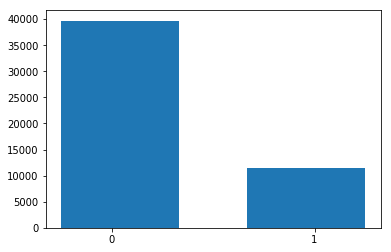

In [20]:
make_bar(data)

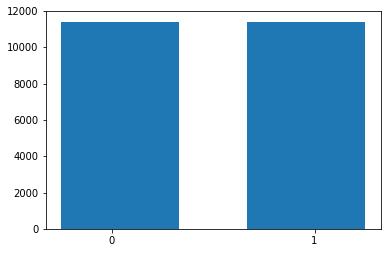

In [21]:
aki_ct = len(data[data.hcc_cd_135 == 1])
no_aki = data[data.hcc_cd_135 == 0].index
random_negatives = np.random.choice(no_aki, aki_ct, replace=False)
idxes = np.concatenate([random_negatives, data[data.hcc_cd_135 == 1].index])
undersampled = data.loc[idxes]

make_bar(undersampled)

In [22]:
undersampled.to_csv('model-data/undersampled.csv', index=False)
data = undersampled.copy(deep=True)
printer('model-data')
print(os.listdir('model-data/'))

model-data
-------------------
['ytrain.csv', 'xtrain.csv', 'xtrain_2.csv', 'xtest.csv', 'ytest.csv', 'data.csv', 'ytrain_2.csv', 'undersampled.csv', 'xtest_2.csv', '.ipynb_checkpoints', 'ytest_2.csv']


**Create Test & Train Data**
---
Split into a training and test set. Preprocess the variables, scale the data individually within each set.

In [39]:
def train_test_split(data):
    data['bin_id'] = data.hadm_id.apply(lambda x: np.random.randint(0,len(data)))
    data['bin_id'] = data.bin_id % 10
    train_df = data.loc[data.bin_id < 7]
    valid_df = data.loc[data.bin_id.isin([7, 8])]
    test_df = data.loc[data.bin_id == 9]
    return train_df, valid_df, test_df

train, valid, test = train_test_split(data)
features = [x for x in train if 'ft_' in x]

printer('split the test/training data')
train.shape
valid.shape
test.shape

split the test/training data
-------------------


(16058, 206)

(4529, 206)

(2249, 206)

In [40]:
def pre_process_data(data, datatype='train'):
    printer(f'\nprocessing data {datatype}')
    floats = [x for x in data if ('age' in x) or ('avg' in x) or ('los' in x)]
    data_means = data.copy(deep=True)

    # for floats replace nulls with average
    if datatype == 'train':
        printer('replacing nulls in these columns with averages')
        print(floats)
    data_means[floats] = data_means[floats].fillna(data_means.mean())

    # for all the other categorical variables, fill nulls with the most frequent
    has_na = [x for x in data_means if data_means[x].hasnans]
    if datatype == 'train':
        printer('replacing nulls in these columns with most frequent')
        print(f'{len(has_na)} columns:')
        print('\n'.join(has_na))
    for i in has_na:
        most_freq = data_means[i].mode().iloc[0]
        data_means[i] = data_means[i].fillna(most_freq)
        
        
    # drop any features that are basically zero
    is_all_zero = [x for x in data_means if (data_means[x] == 0).all()]
    if datatype == 'train':
        printer('drop these columns that are all zero')
        print(f'{len(is_all_zero)} columns:')
        print('\n'.join(is_all_zero))
    data_means = data_means.drop(is_all_zero, axis=1)
    
    # scale the data
    features = [x for x in data_means if 'ft_' in x]
    data_scaled = data_means.copy(deep=True)
    data_scaled[features] = data_means[features].astype(float)
    for i in features:
        data_scaled[i] -= data_scaled[i].mean()
        data_scaled[i] /= data_scaled[i].std()
    data_scaled = pd.concat([data_means[['hadm_id', 'hcc_cd_135']],
                         pd.DataFrame(data_scaled, columns=features)], axis=1)
    if datatype == 'train':
        printer('scaled data')
        print(data_scaled.shape)    
    return data_scaled.set_index('hadm_id'), data_means.set_index('hadm_id')

train, train_no_scaled = pre_process_data(train)
valid, valid_no_scaled = pre_process_data(valid)
test, test_no_scaled = pre_process_data(test, datatype='test')
printer('split the test/training data')
train.shape
valid.shape
test.shape
train.head()


processing data train
-------------------
replacing nulls in these columns with averages
-------------------
['ft_age', 'ft_avg_creatinine', 'ft_avg_hematocrit', 'ft_avg_icu_los_within_30']
replacing nulls in these columns with most frequent
-------------------
146 columns:
ft_creatinine_increase_within_48
ft_creatinine_increase_from_baseline
ft_baseline_creat_gt_1
ft_baseline_creatinine
ft_above_normal_hematocrit
ft_below_normal_hematocrit
ft_way_below_normal_hematocrit
ft_elevated_bp
ft_abnormally_low_bp
ft_hbp_stg_1
ft_hbp_stg_2
ft_hbp_crisis
ft_hbp_stg_2_within_6_hours
ft_hbp_stg_2_within_12_hours
ft_hbp_stg_2_within_24_hours
ft_hbp_stg_2_within_36_hours
ft_hbp_stg_2_within_48_hours
ft_low_blood_ph
ft_low_blood_ph_within_6_hrs
ft_low_blood_ph_within_12_hrs
ft_low_blood_ph_within_24_hrs
ft_low_blood_ph_within_36_hrs
ft_low_blood_ph_within_48_hrs
ft_prior_admission_30
ft_prior_admission_60
ft_prior_admission_90
ft_prior_admission_120
ft_micu_within_30
ft_ccu_within_30
ft_any_nephrot

(16058, 198)

(4529, 190)

(2249, 173)

,hcc_cd_135,ft_age,ft_gender,ft_admit_type_elective,ft_admit_type_emergency,ft_admit_type_urgent,ft_race_american_indian_alaska_native,ft_race_american_indian_alaska_native_federally_recognized_tribe,ft_race_asian,ft_race_asian_asian_indian,ft_race_asian_cambodian,ft_race_asian_chinese,ft_race_asian_filipino,ft_race_asian_japanese,ft_race_asian_korean,ft_race_asian_other,ft_race_asian_thai,ft_race_asian_vietnamese,ft_race_black_african,ft_race_black_african_american,ft_race_black_cape_verdean,ft_race_black_haitian,ft_race_caribbean_island,ft_race_hispanic_latino_central_american_(other),ft_race_hispanic_latino_colombian,ft_race_hispanic_latino_cuban,ft_race_hispanic_latino_dominican,ft_race_hispanic_latino_guatemalan,ft_race_hispanic_latino_honduran,ft_race_hispanic_latino_mexican,ft_race_hispanic_latino_puerto_rican,ft_race_hispanic_latino_salvadoran,ft_race_hispanic_or_latino,ft_race_middle_eastern,ft_race_multi_race_ethnicity,ft_race_native_hawaiian_or_other_pacific_islander,ft_race_other,ft_race_portuguese,ft_race_south_american,ft_race_unable_to_obtain,ft_race_white,ft_race_white_brazilian,ft_race_white_eastern_european,ft_race_white_other_european,ft_race_white_russian,ft_race_missing_info,ft_creatinine_increase_within_48,ft_creatinine_increase_from_baseline,ft_baseline_creat_gt_1,ft_baseline_creatinine,ft_avg_creatinine,ft_avg_hematocrit,ft_above_normal_hematocrit,ft_below_normal_hematocrit,ft_way_below_normal_hematocrit,ft_elevated_bp,ft_abnormally_low_bp,ft_hbp_stg_1,ft_hbp_stg_2,ft_hbp_crisis,ft_hbp_stg_2_within_6_hours,ft_hbp_stg_2_within_12_hours,ft_hbp_stg_2_within_24_hours,ft_hbp_stg_2_within_36_hours,ft_hbp_stg_2_within_48_hours,ft_low_blood_ph,ft_low_blood_ph_within_6_hrs,ft_low_blood_ph_within_12_hrs,ft_low_blood_ph_within_24_hrs,ft_low_blood_ph_within_36_hrs,ft_low_blood_ph_within_48_hrs,ft_hcc_cd_19_dbtes_wo_comp,ft_hcc_cd_137_ckd_stg_4,ft_hcc_cd_136_ckd_stg_5,ft_hcc_cd_85_chf,ft_hcc_cd_108_vascular,ft_prior_admission_30,ft_prior_admission_60,ft_prior_admission_90,ft_prior_admission_120,ft_avg_icu_los_within_30,ft_micu_within_30,ft_ccu_within_30,ft_any_nephrotoxin_rx,ft_any_nephrotoxin_rx_within_24,ft_any_nephrotoxin_rx_within_48,ft_any_nephrotoxin_rx_within_72,ft_nephrotoxin_bacitracin_rx,ft_nephrotoxin_bacitracin_rx_within_24,ft_nephrotoxin_bacitracin_rx_within_48,ft_nephrotoxin_bacitracin_rx_within_72,ft_nephrotoxin_vancomycin_rx,ft_nephrotoxin_vancomycin_rx_within_24,ft_nephrotoxin_vancomycin_rx_within_48,ft_nephrotoxin_vancomycin_rx_within_72,ft_nephrotoxin_amphotericin_rx,ft_nephrotoxin_amphotericin_rx_within_24,ft_nephrotoxin_amphotericin_rx_within_48,ft_nephrotoxin_amphotericin_rx_within_72,ft_nephrotoxin_cephalexin_rx,ft_nephrotoxin_cephalexin_rx_within_24,ft_nephrotoxin_cephalexin_rx_within_48,ft_nephrotoxin_cephalexin_rx_within_72,ft_nephrotoxin_tobramycin_rx,ft_nephrotoxin_tobramycin_rx_within_24,ft_nephrotoxin_tobramycin_rx_within_48,ft_nephrotoxin_tobramycin_rx_within_72,ft_nephrotoxin_gentamicin_rx,ft_nephrotoxin_gentamicin_rx_within_24,ft_nephrotoxin_gentamicin_rx_within_48,ft_nephrotoxin_gentamicin_rx_within_72,ft_nephrotoxin_neomycin_rx,ft_nephrotoxin_neomycin_rx_within_24,ft_nephrotoxin_neomycin_rx_within_48,ft_nephrotoxin_neomycin_rx_within_72,ft_nephrotoxin_ciprofloxacin_rx,ft_nephrotoxin_ciprofloxacin_rx_within_24,ft_nephrotoxin_ciprofloxacin_rx_within_48,ft_nephrotoxin_ciprofloxacin_rx_within_72,ft_nephrotoxin_antibiotics_rx,ft_nephrotoxin_antibiotics_rx_within_24,ft_nephrotoxin_antibiotics_rx_within_48,ft_nephrotoxin_antibiotics_rx_within_72,ft_nephrotoxin_lisinopril_rx,ft_nephrotoxin_lisinopril_rx_within_24,ft_nephrotoxin_lisinopril_rx_within_48,ft_nephrotoxin_lisinopril_rx_within_72,ft_nephrotoxin_ramipril_rx,ft_nephrotoxin_ramipril_rx_within_24,ft_nephrotoxin_ramipril_rx_within_48,ft_nephrotoxin_ramipril_rx_within_72,ft_nephrotoxin_metoprolol_rx,ft_nephrotoxin_metoprolol_rx_within_24,ft_nephrotoxin_metoprolol_rx_within_48,ft_nephrotoxin_metoprolol_rx_within_72,ft_nephrotoxin_candes

In [41]:
train.to_csv('model-data/train.csv')
valid.to_csv('model-data/valid.csv')
test.to_csv('model-data/test.csv')
train_no_scaled.to_csv('model-data/train_no_scaled.csv')
valid_no_scaled.to_csv('model-data/valid_no_scaled.csv')
test_no_scaled.to_csv('model-data/test_no_scaled.csv')
printer('model-data')
print(os.listdir('model-data/'))

model-data
-------------------
['valid.csv', 'archive', 'test.csv', 'data.csv', 'test_no_scaled.csv', 'undersampled.csv', 'valid_no_scaled.csv', 'train_no_scaled.csv', 'train.csv', '.ipynb_checkpoints']


In [42]:
len(undersampled.columns)

205

In [46]:
pd.read_csv('model-data/data.csv',dtype=str, usecols=['hcc_cd_135']).hcc_cd_135.value_counts(normalize=True)

0    0.776613
1    0.223387
Name: hcc_cd_135, dtype: float64

In [48]:
os.listdir('data/')

['DATETIMEEVENTS.csv.gz',
 'CPTEVENTS.csv.gz',
 'PATIENTS.csv.gz',
 'DIAGNOSES_ICD.csv.gz',
 'CAREGIVERS.csv.gz',
 'PRESCRIPTIONS.csv.gz',
 'INPUTEVENTS_MV.csv.gz',
 'DRGCODES.csv.gz',
 'D_ICD_DIAGNOSES.csv.gz',
 'D_LABITEMS.csv.gz',
 'ADMISSIONS.csv.gz',
 'README.md',
 'D_ITEMS.csv.gz',
 'checksum_md5_zipped.txt',
 'CALLOUT.csv.gz',
 'D_CPT.csv.gz',
 'LABEVENTS.csv.gz',
 '.ipynb_checkpoints',
 'PROCEDURES_ICD.csv.gz',
 'CHARTEVENTS.csv.gz',
 'SERVICES.csv.gz',
 'LICENSE.txt',
 'D_ICD_PROCEDURES.csv.gz',
 'SHA256SUMS.txt',
 'ICUSTAYS.csv.gz',
 'INPUTEVENTS_CV.csv.gz',
 'NOTEEVENTS.csv.gz',
 'checksum_md5_unzipped.txt',
 'MICROBIOLOGYEVENTS.csv.gz']